# Universal Strategy Analysis

This notebook provides comprehensive analysis across all strategies tested in a parameter sweep.

**Key Features:**
- Cross-strategy performance comparison
- Parameter sensitivity analysis
- Stop loss and profit target analysis with CORRECT implementation
- Correlation analysis for ensemble building
- Regime-specific performance breakdown
- Automatic identification of optimal strategies and ensembles

In [1]:
# Parameters will be injected here by papermill
# This cell is tagged with 'parameters' for papermill to recognize it
run_dir = "."
config_name = "config"
symbols = ["SPY"]
timeframe = "5m"
global_traces_dir = "/Users/daws/ADMF-PC/traces"  # Global traces directory
min_strategies_to_analyze = 20
sharpe_threshold = 1.0
correlation_threshold = 0.7
top_n_strategies = 10
ensemble_size = 5
calculate_all_performance = True  # Set to False to limit analysis for large sweeps
performance_limit = 100  # If calculate_all_performance is False, limit to this many

# Enhanced analysis parameters
execution_cost_bps = 1.0  # Round-trip execution cost in basis points
analyze_stop_losses = True  # Whether to analyze stop loss impact
stop_loss_levels = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.75, 1.0]  # Stop loss percentages
profit_target_levels = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1.0]  # Profit target percentages
verify_intraday = True  # Whether to verify intraday constraints
market_timezone = "America/New_York"  # Market timezone for constraint verification

In [2]:
# Parameters
run_dir = "/Users/daws/ADMF-PC/config/bollinger/results/20250629_162516"
config_name = "bollinger"
symbols = ["SPY"]
timeframe = "5m"
global_traces_dir = "/Users/daws/ADMF-PC/traces"
min_strategies_to_analyze = 20
sharpe_threshold = 1.0
correlation_threshold = 0.7
top_n_strategies = 10
ensemble_size = 5
calculate_all_performance = True
performance_limit = 100


## Setup

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import duckdb
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Initialize DuckDB
con = duckdb.connect()

# Convert run_dir to Path and resolve to absolute path
run_dir = Path(run_dir).resolve()
print(f"Analyzing run: {run_dir.name}")
print(f"Full path: {run_dir}")
print(f"Config: {config_name}")
print(f"Symbol(s): {symbols}")
print(f"Timeframe: {timeframe}")

Analyzing run: 20250629_162516
Full path: /Users/daws/ADMF-PC/config/bollinger/results/20250629_162516
Config: bollinger
Symbol(s): ['SPY']
Timeframe: 5m


In [4]:
# Setup path for loading analysis snippets
import sys
import os
from pathlib import Path

# Find the project root (where src/ directory is)
current_path = Path(run_dir).resolve()
project_root = None

# Search up the directory tree for src/analytics/snippets
for parent in current_path.parents:
    if (parent / 'src' / 'analytics' / 'snippets').exists():
        project_root = parent
        break

# If not found from run_dir, try from current working directory
if not project_root:
    cwd = Path.cwd()
    for parent in [cwd] + list(cwd.parents):
        if (parent / 'src' / 'analytics' / 'snippets').exists():
            project_root = parent
            break

# Last resort: check common project locations
if not project_root:
    common_roots = [
        Path('/Users/daws/ADMF-PC'),
        Path.home() / 'ADMF-PC',
        Path.cwd().parent.parent.parent.parent  # 4 levels up from typical results dir
    ]
    for root in common_roots:
        if root.exists() and (root / 'src' / 'analytics' / 'snippets').exists():
            project_root = root
            break

if project_root:
    # Add to Python path if not already there
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    
    snippets_path = project_root / 'src' / 'analytics' / 'snippets'
    queries_path = project_root / 'src' / 'analytics' / 'queries'
    
    # IMPORTANT: Change working directory to snippets folder
    # This allows %run snippet.py to work directly
    original_cwd = os.getcwd()
    os.chdir(snippets_path)
    
    print(f"✅ Found project root: {project_root}")
    print(f"✅ Changed working directory to: {snippets_path}")
    print(f"✅ Original working directory saved as: {original_cwd}")
    
    # List available snippets
    print("\n📂 Available snippets (use %run filename.py):")
    for py_file in sorted(snippets_path.glob("*.py")):
        if not py_file.name.startswith('_'):
            print(f"  - {py_file.name}")
    
    # List subdirectories
    subdirs = [d for d in snippets_path.iterdir() if d.is_dir() and not d.name.startswith('_')]
    if subdirs:
        print("\n📁 Subdirectories:")
        for subdir in sorted(subdirs):
            print(f"  - {subdir.name}/")
            # Show a few files in each subdirectory
            sub_files = list(subdir.glob("*.py"))[:3]
            for f in sub_files:
                print(f"      %run {subdir.name}/{f.name}")
    
    print("\n💡 Usage examples:")
    print("  %run stop_loss_analysis_correct.py")
    print("  %run stop_target_analysis_comprehensive.py")
    print("  %run exploratory/signal_frequency.py")
    print("  %run ensembles/find_uncorrelated.py")
    
    # Store paths for later use
    _snippet_paths = {
        'project_root': project_root,
        'snippets': snippets_path,
        'queries': queries_path,
        'original_cwd': original_cwd
    }
else:
    print("⚠️ Could not find project root with src/analytics/snippets")
    print(f"  Searched from: {current_path}")
    print(f"  Current working directory: {Path.cwd()}")

✅ Found project root: /Users/daws/ADMF-PC
✅ Changed working directory to: /Users/daws/ADMF-PC/src/analytics/snippets
✅ Original working directory saved as: /Users/daws/ADMF-PC

📂 Available snippets (use %run filename.py):
  - alternative_risk_management.py
  - analyze_bollinger_signals_directly.py
  - check_fill_metadata.py
  - check_notebook_entry_logic.py
  - check_optimization_logic.py
  - compare_5edc4365.py
  - compare_trades_direct.py
  - complete_high_frequency_analysis.py
  - complete_stop_target_analysis.py
  - complete_stop_target_analysis_enhanced.py
  - compound_sharpe_explanation.py
  - comprehensive_1m_bollinger_analysis.py
  - comprehensive_1m_bollinger_self_contained.py
  - comprehensive_bollinger_direct.py
  - comprehensive_bollinger_full_featured.py
  - comprehensive_bollinger_standalone.py
  - corrected_performance_analysis.py
  - debug_1550_trade.py
  - debug_analysis_target_logic.py
  - debug_entry_exit_timing.py
  - debug_signal_flipping.py
  - debug_stop_loss_iss

In [5]:
# Setup path for loading analysis snippets
import sys
from pathlib import Path

# Find the project root (where src/ directory is)
current_path = Path(run_dir).resolve()
project_root = None

# Search up the directory tree for src/analytics/snippets
for parent in current_path.parents:
    if (parent / 'src' / 'analytics' / 'snippets').exists():
        project_root = parent
        break

# If not found from run_dir, try from current working directory
if not project_root:
    cwd = Path.cwd()
    for parent in [cwd] + list(cwd.parents):
        if (parent / 'src' / 'analytics' / 'snippets').exists():
            project_root = parent
            break

# Last resort: check common project locations
if not project_root:
    common_roots = [
        Path('/Users/daws/ADMF-PC'),
        Path.home() / 'ADMF-PC',
        Path.cwd().parent.parent.parent.parent  # 4 levels up from typical results dir
    ]
    for root in common_roots:
        if root.exists() and (root / 'src' / 'analytics' / 'snippets').exists():
            project_root = root
            break

if project_root:
    # Add to Python path if not already there
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    snippets_path = project_root / 'src' / 'analytics' / 'snippets'
    queries_path = project_root / 'src' / 'analytics' / 'queries'
    print(f"✅ Found project root: {project_root}")
    print(f"✅ Analysis snippets available at: {snippets_path}")
    print(f"✅ SQL queries available at: {queries_path}")
    
    # Now you can import snippets as modules
    print("\nYou can now import snippets directly:")
    print("  from src.analytics.snippets.stop_loss_analysis_correct import calculate_stop_loss_impact")
    print("  from src.analytics.snippets.stop_target_analysis_comprehensive import apply_stop_target")
    print("\nOr use %load to load any snippet:")
    print("  %load {}/src/analytics/snippets/exploratory/signal_frequency.py".format(project_root))
    print("  %load {}/src/analytics/snippets/ensembles/find_uncorrelated.py".format(project_root))
else:
    print("⚠️ Could not find project root with src/analytics/snippets")
    print(f"  Searched from: {current_path}")
    print(f"  Current working directory: {Path.cwd()}")

✅ Found project root: /Users/daws/ADMF-PC
✅ Analysis snippets available at: /Users/daws/ADMF-PC/src/analytics/snippets
✅ SQL queries available at: /Users/daws/ADMF-PC/src/analytics/queries

You can now import snippets directly:
  from src.analytics.snippets.stop_loss_analysis_correct import calculate_stop_loss_impact
  from src.analytics.snippets.stop_target_analysis_comprehensive import apply_stop_target

Or use %load to load any snippet:
  %load /Users/daws/ADMF-PC/src/analytics/snippets/exploratory/signal_frequency.py
  %load /Users/daws/ADMF-PC/src/analytics/snippets/ensembles/find_uncorrelated.py


## Enhanced Analysis Helper Functions

In [6]:
# Enhanced analysis helper functions
import pytz
from datetime import time

def extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps=1.0):
    """
    Extract trades from signal trace with execution costs.
    
    Args:
        strategy_hash: Strategy identifier
        trace_path: Path to trace file (can be relative or absolute)
        market_data: Market price data
        execution_cost_bps: Round-trip execution cost in basis points (default 1bp)
    
    Returns:
        DataFrame with trade details including costs
    """
    try:
        # Handle both relative paths (from strategy_index) and absolute paths
        if isinstance(trace_path, str) and trace_path.startswith('/'):
            # Absolute path from global_trace_path
            signals_path = Path(trace_path)
        else:
            # Relative path within run_dir
            signals_path = run_dir / trace_path
            
        signals = pd.read_parquet(signals_path)
        signals['ts'] = pd.to_datetime(signals['ts'])
        
        # Merge with market data
        df = market_data.merge(
            signals[['ts', 'val', 'px']], 
            left_on='timestamp', 
            right_on='ts', 
            how='left'
        )
        
        # Forward fill signals
        df['signal'] = df['val'].ffill().fillna(0)
        df['position'] = df['signal'].replace({0: 0, 1: 1, -1: -1})
        df['position_change'] = df['position'].diff().fillna(0)
        
        trades = []
        current_trade = None
        
        for idx, row in df.iterrows():
            if row['position_change'] != 0 and row['position'] != 0:
                # New position opened
                if current_trade is None:
                    current_trade = {
                        'entry_time': row['timestamp'],
                        'entry_price': row['px'] if pd.notna(row['px']) else row['close'],
                        'direction': row['position'],
                        'entry_idx': idx
                    }
            elif current_trade is not None and (row['position'] == 0 or row['position_change'] != 0):
                # Position closed
                exit_price = row['px'] if pd.notna(row['px']) else row['close']
                
                # Avoid division by zero - check if entry price is valid
                if current_trade['entry_price'] == 0 or pd.isna(current_trade['entry_price']):
                    print(f"Warning: Invalid entry price {current_trade['entry_price']} for trade at {current_trade['entry_time']}")
                    current_trade = None
                    continue
                
                # Calculate raw return
                if current_trade['direction'] == 1:  # Long
                    raw_return = (exit_price - current_trade['entry_price']) / current_trade['entry_price']
                else:  # Short
                    raw_return = (current_trade['entry_price'] - exit_price) / current_trade['entry_price']
                
                # Apply execution costs
                cost_adjustment = execution_cost_bps / 10000  # Convert bps to decimal
                net_return = raw_return - cost_adjustment
                
                trade = {
                    'strategy_hash': strategy_hash,
                    'entry_time': current_trade['entry_time'],
                    'exit_time': row['timestamp'],
                    'entry_price': current_trade['entry_price'],
                    'exit_price': exit_price,
                    'direction': current_trade['direction'],
                    'raw_return': raw_return,
                    'execution_cost': cost_adjustment,
                    'net_return': net_return,
                    'duration_minutes': (row['timestamp'] - current_trade['entry_time']).total_seconds() / 60,
                    'entry_idx': current_trade['entry_idx'],
                    'exit_idx': idx
                }
                trades.append(trade)
                
                # Reset for next trade
                current_trade = None
                if row['position'] != 0 and row['position_change'] != 0:
                    # Immediately open new position (reversal)
                    current_trade = {
                        'entry_time': row['timestamp'],
                        'entry_price': row['px'] if pd.notna(row['px']) else row['close'],
                        'direction': row['position'],
                        'entry_idx': idx
                    }
        
        return pd.DataFrame(trades)
    except Exception as e:
        print(f"Error extracting trades for {strategy_hash[:8]}: {e}")
        return pd.DataFrame()

In [7]:
def calculate_stop_loss_impact(trades_df, stop_loss_levels=None, market_data=None):
    """
    Calculate returns with various stop loss levels using PROPER intraday simulation.
    
    THIS IS THE CORRECT IMPLEMENTATION:
    - Checks actual intraday high/low prices
    - Exits immediately when stop is hit
    - Stops out trades that would have been winners too
    - Does NOT retrospectively cap losses
    - IMPORTANT: Fixed lookahead bias - now starts checking from entry_idx+1
    """
    if stop_loss_levels is None:
        stop_loss_levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1.0]
    
    if market_data is None:
        raise ValueError("Market data is required for proper stop loss analysis!")
    
    results = []
    
    for sl_pct in stop_loss_levels:
        sl_decimal = sl_pct / 100
        
        trades_with_sl = []
        stopped_out_count = 0
        stopped_winners = 0  # Trades that were stopped but would have been winners
        
        # Process each trade with intraday stop loss
        for _, trade in trades_df.iterrows():
            # IMPORTANT FIX: Start from entry_idx+1 to avoid lookahead bias
            # We cannot check the entry bar's high/low when we enter at close
            trade_prices = market_data.iloc[int(trade['entry_idx'])+1:int(trade['exit_idx'])+1]
            
            if len(trade_prices) == 0:
                continue
                
            entry_price = trade['entry_price']
            direction = trade['direction']
            original_return = trade['net_return']  # What the trade actually returned
            
            # Calculate stop loss price
            if direction == 1:  # Long position
                stop_price = entry_price * (1 - sl_decimal)
            else:  # Short position  
                stop_price = entry_price * (1 + sl_decimal)
            
            # Check if stop loss is hit
            stopped = False
            exit_price = trade['exit_price']
            exit_time = trade['exit_time']
            
            for idx, bar in trade_prices.iterrows():
                if direction == 1:  # Long
                    # Check if low price hits stop
                    if bar['low'] <= stop_price:
                        stopped = True
                        stopped_out_count += 1
                        exit_price = stop_price
                        exit_time = bar['timestamp']
                        # Check if this would have been a winner
                        if original_return > 0:
                            stopped_winners += 1
                        break
                else:  # Short
                    # Check if high price hits stop
                    if bar['high'] >= stop_price:
                        stopped = True
                        stopped_out_count += 1
                        exit_price = stop_price
                        exit_time = bar['timestamp']
                        # Check if this would have been a winner
                        if original_return > 0:
                            stopped_winners += 1
                        break
            
            # Calculate return with actual or stopped exit
            if direction == 1:  # Long
                raw_return = (exit_price - entry_price) / entry_price
            else:  # Short
                raw_return = (entry_price - exit_price) / entry_price
                
            # Apply execution costs
            net_return = raw_return - trade['execution_cost']
            
            trade_result = trade.copy()
            trade_result['raw_return'] = raw_return
            trade_result['net_return'] = net_return
            trade_result['stopped_out'] = stopped
            if stopped:
                trade_result['exit_price'] = exit_price
                trade_result['exit_time'] = exit_time
                
            trades_with_sl.append(trade_result)
        
        trades_with_sl_df = pd.DataFrame(trades_with_sl)
        
        if len(trades_with_sl_df) > 0:
            # Calculate metrics with stop loss
            total_return = trades_with_sl_df['net_return'].sum()
            avg_return = trades_with_sl_df['net_return'].mean()
            win_rate = (trades_with_sl_df['net_return'] > 0).mean()
            
            results.append({
                'stop_loss_pct': sl_pct,
                'total_return': total_return,
                'avg_return_per_trade': avg_return,
                'win_rate': win_rate,
                'stopped_out_count': stopped_out_count,
                'stopped_out_rate': stopped_out_count / len(trades_with_sl_df),
                'stopped_winners': stopped_winners,
                'stopped_winners_pct': stopped_winners / len(trades_with_sl_df) * 100,
                'num_trades': len(trades_with_sl_df),
                'avg_winner': trades_with_sl_df[trades_with_sl_df['net_return'] > 0]['net_return'].mean() if (trades_with_sl_df['net_return'] > 0).any() else 0,
                'avg_loser': trades_with_sl_df[trades_with_sl_df['net_return'] <= 0]['net_return'].mean() if (trades_with_sl_df['net_return'] <= 0).any() else 0
            })
    
    return pd.DataFrame(results)

In [8]:
def apply_stop_target(trades_df, stop_pct, target_pct, market_data):
    """
    Apply both stop loss and profit target to trades.
    
    CORRECT IMPLEMENTATION:
    - Checks intraday prices bar by bar
    - Exits at first target hit (stop or profit)
    - Properly tracks which exit was triggered
    - Works for both long and short positions
    - IMPORTANT: Fixed lookahead bias - now starts checking from entry_idx+1
    """
    if stop_pct == 0 and target_pct == 0:
        # No modification - return original
        return trades_df['net_return'].values, {'stop': 0, 'target': 0, 'signal': len(trades_df)}
    
    modified_returns = []
    exit_types = {'stop': 0, 'target': 0, 'signal': 0}
    stopped_winners = 0
    
    for _, trade in trades_df.iterrows():
        # IMPORTANT FIX: Start from entry_idx+1 to avoid lookahead bias
        # We cannot check the entry bar's high/low when we enter at close
        trade_prices = market_data.iloc[int(trade['entry_idx'])+1:int(trade['exit_idx'])+1]
        
        if len(trade_prices) == 0:
            modified_returns.append(trade['net_return'])
            exit_types['signal'] += 1
            continue
        
        entry_price = trade['entry_price']
        direction = trade['direction']
        original_return = trade['net_return']
        
        # Set stop and target prices
        if direction == 1:  # Long
            stop_price = entry_price * (1 - stop_pct/100) if stop_pct > 0 else 0
            target_price = entry_price * (1 + target_pct/100) if target_pct > 0 else float('inf')
        else:  # Short
            stop_price = entry_price * (1 + stop_pct/100) if stop_pct > 0 else float('inf')
            target_price = entry_price * (1 - target_pct/100) if target_pct > 0 else 0
        
        # Check each bar for exit
        exit_price = trade['exit_price']
        exit_type = 'signal'
        
        for _, bar in trade_prices.iterrows():
            if direction == 1:  # Long
                # Check stop first (more conservative)
                if stop_pct > 0 and bar['low'] <= stop_price:
                    exit_price = stop_price
                    exit_type = 'stop'
                    if original_return > 0:
                        stopped_winners += 1
                    break
                # Then check target
                elif target_pct > 0 and bar['high'] >= target_price:
                    exit_price = target_price
                    exit_type = 'target'
                    break
            else:  # Short
                # Check stop first
                if stop_pct > 0 and bar['high'] >= stop_price:
                    exit_price = stop_price
                    exit_type = 'stop'
                    if original_return > 0:
                        stopped_winners += 1
                    break
                # Then check target
                elif target_pct > 0 and bar['low'] <= target_price:
                    exit_price = target_price
                    exit_type = 'target'
                    break
        
        exit_types[exit_type] += 1
        
        # Calculate return
        if direction == 1:
            raw_return = (exit_price - entry_price) / entry_price
        else:
            raw_return = (entry_price - exit_price) / entry_price
        
        net_return = raw_return - trade['execution_cost']
        modified_returns.append(net_return)
    
    # Add stopped winners info
    exit_types['stopped_winners'] = stopped_winners
    
    return np.array(modified_returns), exit_types

In [9]:
def calculate_compound_sharpe(returns, periods_per_year=None):
    """
    Calculate Sharpe ratio using geometric mean (compound returns) instead of arithmetic mean.
    
    This better reflects actual investor experience and avoids the "low volatility trap"
    where strategies with consistent small losses appear attractive.
    
    Args:
        returns: Array of period returns
        periods_per_year: Number of periods in a year for annualization
                         If None, will estimate from return count
    
    Returns:
        Compound Sharpe ratio
    """
    if len(returns) == 0 or returns.std() == 0:
        return 0.0
    
    # Calculate compound return
    compound_return = (1 + returns).prod() - 1
    
    # Calculate geometric mean
    n_periods = len(returns)
    geometric_mean = (1 + compound_return)**(1/n_periods) - 1
    
    # Estimate annualization factor if not provided
    if periods_per_year is None:
        # Assume daily returns and 252 trading days
        periods_per_year = 252
    
    # Calculate compound Sharpe ratio
    # Note: We use the same volatility (std dev) as traditional Sharpe
    # but with geometric mean instead of arithmetic mean
    compound_sharpe = geometric_mean / returns.std() * np.sqrt(periods_per_year)
    
    return compound_sharpe

def calculate_both_sharpes(returns, periods_per_year=None):
    """
    Calculate both traditional and compound Sharpe ratios for comparison.
    
    Returns:
        dict with 'traditional' and 'compound' Sharpe ratios
    """
    if len(returns) == 0 or returns.std() == 0:
        return {'traditional': 0.0, 'compound': 0.0}
    
    # Traditional Sharpe (arithmetic mean)
    if periods_per_year is None:
        periods_per_year = 252
    
    traditional_sharpe = returns.mean() / returns.std() * np.sqrt(periods_per_year)
    
    # Compound Sharpe (geometric mean)
    compound_sharpe = calculate_compound_sharpe(returns, periods_per_year)
    
    return {
        'traditional': traditional_sharpe,
        'compound': compound_sharpe,
        'arithmetic_mean': returns.mean(),
        'geometric_mean': ((1 + returns).prod()**(1/len(returns)) - 1),
        'volatility': returns.std()
    }

## Load Strategy Index and Market Data

In [10]:
# Load strategy index - the catalog of all strategies tested
strategy_index_path = run_dir / 'strategy_index.parquet'

if strategy_index_path.exists():
    strategy_index = pd.read_parquet(strategy_index_path)
    print(f"✅ Loaded {len(strategy_index)} strategies from {strategy_index_path}")
    
    # Show strategy type distribution
    by_type = strategy_index['strategy_type'].value_counts()
    print("\nStrategies by type:")
    for stype, count in by_type.items():
        print(f"  {stype}: {count}")
        
    # Show sample of columns
    print(f"\nColumns: {list(strategy_index.columns)[:10]}...")
else:
    print(f"❌ No strategy_index.parquet found at {strategy_index_path}")
    strategy_index = None

✅ Loaded 205 strategies from /Users/daws/ADMF-PC/config/bollinger/results/20250629_162516/strategy_index.parquet

Strategies by type:
  bollinger_bands: 205

Columns: ['strategy_id', 'strategy_hash', 'strategy_type', 'symbol', 'timeframe', 'constraints', 'global_trace_path', 'period', 'std_dev']...


In [11]:
# Load market data
market_data = None
for symbol in symbols:
    try:
        # Try different possible locations for market data
        data_paths = [
            run_dir / f'data/{symbol}_{timeframe}.csv',
            run_dir / f'{symbol}_{timeframe}.csv',
            run_dir.parent / f'data/{symbol}_{timeframe}.csv',
            Path(f'/Users/daws/ADMF-PC/data/{symbol}_{timeframe}.csv')
        ]
        
        for data_path in data_paths:
            if data_path.exists():
                market_data = pd.read_csv(data_path)
                market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
                market_data = market_data.sort_values('timestamp')
                print(f"✅ Loaded market data from: {data_path}")
                print(f"   Date range: {market_data['timestamp'].min()} to {market_data['timestamp'].max()}")
                print(f"   Total bars: {len(market_data)}")
                break
        
        if market_data is not None:
            break
            
    except Exception as e:
        print(f"Error loading data for {symbol}: {e}")

if market_data is None:
    print("❌ Could not load market data")
    print("Tried paths:")
    for path in data_paths:
        print(f"  - {path}")

✅ Loaded market data from: /Users/daws/ADMF-PC/data/SPY_5m.csv
   Date range: 2024-03-26 13:30:00+00:00 to 2025-04-02 19:20:00+00:00
   Total bars: 20769


## Calculate Performance Metrics

In [12]:
def calculate_performance(strategy_hash, trace_path, market_data, execution_cost_bps=1.0, use_compound_sharpe=True):
    """Calculate performance metrics using TRADE-BASED approach for consistency"""
    try:
        # Extract actual trades
        trades = extract_trades(strategy_hash, trace_path, market_data, execution_cost_bps)
        
        if len(trades) == 0:
            return {
                'total_return': 0,
                'sharpe_ratio': 0,
                'compound_sharpe_ratio': 0,
                'max_drawdown': 0,
                'num_trades': 0,
                'win_rate': 0,
                'avg_return_per_trade': 0,
                'profit_factor': 0,
                'total_execution_cost': 0,
                'avg_winner': 0,
                'avg_loser': 0
            }
        
        # Calculate cumulative returns from trades
        trades = trades.sort_values('entry_time').reset_index(drop=True)
        trades['cum_return'] = (1 + trades['net_return']).cumprod()
        total_return = trades['cum_return'].iloc[-1] - 1
        
        # Calculate both Sharpe ratios from trade returns
        if trades['net_return'].std() > 0:
            # Annualize based on average trades per day
            days_in_data = (trades['exit_time'].max() - trades['entry_time'].min()).days
            if days_in_data > 0:
                trades_per_day = len(trades) / days_in_data
                annualization_factor = np.sqrt(252 * trades_per_day)
            else:
                annualization_factor = np.sqrt(252)
            
            # Traditional Sharpe (arithmetic mean)
            traditional_sharpe = trades['net_return'].mean() / trades['net_return'].std() * annualization_factor
            
            # Compound Sharpe (geometric mean)
            geometric_mean = (1 + total_return)**(1/len(trades)) - 1
            compound_sharpe = geometric_mean / trades['net_return'].std() * annualization_factor
        else:
            traditional_sharpe = 0
            compound_sharpe = 0
            
        # Max drawdown from trade equity curve
        cummax = trades['cum_return'].expanding().max()
        drawdown = (trades['cum_return'] / cummax - 1)
        max_dd = drawdown.min()
        
        # Win rate and profit factor (trade-based)
        winning_trades = trades[trades['net_return'] > 0]
        losing_trades = trades[trades['net_return'] <= 0]
        
        win_rate = len(winning_trades) / len(trades)
        
        if len(losing_trades) > 0 and losing_trades['net_return'].sum() != 0:
            profit_factor = winning_trades['net_return'].sum() / abs(losing_trades['net_return'].sum())
        else:
            profit_factor = 999.99 if len(winning_trades) > 0 else 0
        
        return {
            'total_return': total_return,
            'sharpe_ratio': compound_sharpe if use_compound_sharpe else traditional_sharpe,
            'traditional_sharpe_ratio': traditional_sharpe,
            'compound_sharpe_ratio': compound_sharpe,
            'max_drawdown': max_dd,
            'num_trades': len(trades),
            'win_rate': win_rate,
            'avg_return_per_trade': trades['net_return'].mean(),
            'profit_factor': profit_factor,
            'avg_winner': winning_trades['net_return'].mean() if len(winning_trades) > 0 else 0,
            'avg_loser': losing_trades['net_return'].mean() if len(losing_trades) > 0 else 0,
            'total_execution_cost': trades['execution_cost'].sum()
        }
    except Exception as e:
        print(f"Error calculating performance for {strategy_hash}: {e}")
        return None

In [13]:
# Calculate performance for all strategies with execution costs
if strategy_index is not None and market_data is not None:
    performance_results = []
    
    # Determine strategies to analyze based on parameters
    strategies_to_analyze = strategy_index
    
    if not calculate_all_performance and len(strategy_index) > performance_limit:
        print(f"Note: Large parameter sweep detected ({len(strategy_index)} strategies)")
        print(f"Limiting analysis to {performance_limit} strategies (set calculate_all_performance=True to analyze all)")
        
        # Sample diverse strategies across all types
        strategies_to_analyze = strategy_index.groupby('strategy_type').apply(
            lambda x: x.sample(n=min(len(x), performance_limit // strategy_index['strategy_type'].nunique()), 
                             random_state=42)
        ).reset_index(drop=True)
    
    print(f"\nCalculating performance for {len(strategies_to_analyze)} strategies...")
    print(f"Using run directory: {run_dir}")
    print(f"Execution cost: {execution_cost_bps} basis points round-trip")
    print(f"📊 Using TRADE-BASED metrics (win rate = winning trades / total trades)")
    
    for idx, row in strategies_to_analyze.iterrows():
        if idx % 10 == 0:
            print(f"  Progress: {idx}/{len(strategies_to_analyze)} ({idx/len(strategies_to_analyze)*100:.1f}%)")
        
        # Use global_trace_path if available, otherwise trace_path
        trace_path = row.get('global_trace_path', row.get('trace_path', None))
        
        if trace_path:
            perf = calculate_performance(row['strategy_hash'], trace_path, market_data, execution_cost_bps)
            
            if perf:
                # Combine strategy info with performance
                result = {**row.to_dict(), **perf}
                performance_results.append(result)
    
    print(f"  Progress: {len(strategies_to_analyze)}/{len(strategies_to_analyze)} (100.0%)")
    
    performance_df = pd.DataFrame(performance_results)
    print(f"\n✅ Calculated performance for {len(performance_df)} strategies")
else:
    performance_df = pd.DataFrame()
    print("⚠️ Skipping performance calculation")


Calculating performance for 205 strategies...
Using run directory: /Users/daws/ADMF-PC/config/bollinger/results/20250629_162516
Execution cost: 1.0 basis points round-trip
📊 Using TRADE-BASED metrics (win rate = winning trades / total trades)
  Progress: 0/205 (0.0%)


  Progress: 10/205 (4.9%)


  Progress: 20/205 (9.8%)


  Progress: 30/205 (14.6%)


  Progress: 40/205 (19.5%)


  Progress: 50/205 (24.4%)


  Progress: 60/205 (29.3%)


  Progress: 70/205 (34.1%)


  Progress: 80/205 (39.0%)


  Progress: 90/205 (43.9%)


  Progress: 100/205 (48.8%)


  Progress: 110/205 (53.7%)


  Progress: 120/205 (58.5%)


  Progress: 130/205 (63.4%)


  Progress: 140/205 (68.3%)


  Progress: 150/205 (73.2%)


  Progress: 160/205 (78.0%)


  Progress: 170/205 (82.9%)


  Progress: 180/205 (87.8%)


  Progress: 190/205 (92.7%)


  Progress: 200/205 (97.6%)


  Progress: 205/205 (100.0%)

✅ Calculated performance for 205 strategies


In [14]:
# Display top strategies with key metrics
if len(performance_df) > 0:
    print("\n🏆 Top 20 Strategies by Compound Sharpe Ratio (with Win Rate & Avg Return/Trade)")
    print("=" * 140)
    print("📊 Note: Using Compound Sharpe Ratio which better reflects actual investor returns")
    
    # Sort by Sharpe ratio and show top strategies
    top_strategies = performance_df.nlargest(20, 'sharpe_ratio')
    
    # Display metrics in a formatted way
    print(f"{'Rank':<5} {'Strategy Type':<20} {'Compound':<10} {'Traditional':<12} {'Total Return':<12} {'Win Rate':<10} {'Avg Return/Trade':<16} {'# Trades':<10}")
    print(f"{'':5} {'':20} {'Sharpe':<10} {'Sharpe':<12} {'':12} {'':10} {'':16} {'':10}")
    print("-" * 140)
    
    for idx, (_, row) in enumerate(top_strategies.iterrows(), 1):
        compound_sharpe = row.get('compound_sharpe_ratio', row['sharpe_ratio'])
        traditional_sharpe = row.get('traditional_sharpe_ratio', row['sharpe_ratio'])
        print(f"{idx:<5} {row['strategy_type']:<20} {compound_sharpe:>9.2f} {traditional_sharpe:>11.2f} {row['total_return']*100:>11.1f}% {row['win_rate']*100:>9.1f}% {row['avg_return_per_trade']*100:>15.3f}% {row['num_trades']:>9}")
    
    # Summary statistics
    print("\n📊 Overall Performance Summary:")
    print(f"Total strategies analyzed: {len(performance_df)}")
    print(f"Average win rate: {performance_df['win_rate'].mean()*100:.1f}%")
    print(f"Average return per trade: {performance_df['avg_return_per_trade'].mean()*100:.3f}%")
    print(f"Strategies with positive Compound Sharpe: {(performance_df['sharpe_ratio'] > 0).sum()} ({(performance_df['sharpe_ratio'] > 0).mean()*100:.1f}%)")
    print(f"Strategies with win rate > 50%: {(performance_df['win_rate'] > 0.5).sum()} ({(performance_df['win_rate'] > 0.5).mean()*100:.1f}%)")
    
    # Compare compound vs traditional Sharpe
    if 'compound_sharpe_ratio' in performance_df.columns and 'traditional_sharpe_ratio' in performance_df.columns:
        print("\n📈 Compound vs Traditional Sharpe Analysis:")
        print(f"Average Compound Sharpe: {performance_df['compound_sharpe_ratio'].mean():.3f}")
        print(f"Average Traditional Sharpe: {performance_df['traditional_sharpe_ratio'].mean():.3f}")
        print(f"Strategies where Compound < Traditional: {(performance_df['compound_sharpe_ratio'] < performance_df['traditional_sharpe_ratio']).sum()} ({(performance_df['compound_sharpe_ratio'] < performance_df['traditional_sharpe_ratio']).mean()*100:.1f}%)")
        print("(This is expected due to volatility drag)")
    
    # Distribution analysis
    print("\n📈 Win Rate Distribution:")
    win_rate_bins = [0, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 1.0]
    win_rate_labels = ['< 30%', '30-40%', '40-45%', '45-50%', '50-55%', '55-60%', '60-70%', '> 70%']
    performance_df['win_rate_bin'] = pd.cut(performance_df['win_rate'], bins=win_rate_bins, labels=win_rate_labels)
    win_rate_dist = performance_df['win_rate_bin'].value_counts().sort_index()
    
    for bin_label, count in win_rate_dist.items():
        pct = count / len(performance_df) * 100
        print(f"  {bin_label}: {count} strategies ({pct:.1f}%)")
    
    # Average return per trade distribution
    print("\n💰 Average Return per Trade Distribution:")
    return_bins = [-np.inf, -0.005, -0.002, 0, 0.002, 0.005, 0.01, np.inf]
    return_labels = ['< -0.5%', '-0.5% to -0.2%', '-0.2% to 0%', '0% to 0.2%', '0.2% to 0.5%', '0.5% to 1%', '> 1%']
    performance_df['return_bin'] = pd.cut(performance_df['avg_return_per_trade'], bins=return_bins, labels=return_labels)
    return_dist = performance_df['return_bin'].value_counts().sort_index()
    
    for bin_label, count in return_dist.items():
        pct = count / len(performance_df) * 100
        print(f"  {bin_label}: {count} strategies ({pct:.1f}%)")


🏆 Top 20 Strategies by Compound Sharpe Ratio (with Win Rate & Avg Return/Trade)
📊 Note: Using Compound Sharpe Ratio which better reflects actual investor returns
Rank  Strategy Type        Compound   Traditional  Total Return Win Rate   Avg Return/Trade # Trades  
                           Sharpe     Sharpe                                                          
--------------------------------------------------------------------------------------------------------------------------------------------
1     bollinger_bands           0.50        0.51         0.6%      55.6%           0.013%        45
2     bollinger_bands           0.43        0.43         0.5%      52.9%           0.007%        70
3     bollinger_bands           0.00         nan         0.0%       0.0%           0.000%         0
4     bollinger_bands          -0.13       -0.12        -0.2%      50.6%          -0.001%       176
5     bollinger_bands          -0.19       -0.18        -0.3%      50.9%          -0.002% 

## Stop Loss and Profit Target Optimization

In [15]:
# Optimize stop loss and profit target for each strategy using COMPOUND SHARPE
if len(performance_df) > 0 and analyze_stop_losses:
    print("\n🎯 Optimizing Stop Loss and Profit Target for Each Strategy (Using Compound Sharpe)")
    print("=" * 80)
    print("📊 Note: Now using Compound Sharpe Ratio which better reflects actual investor returns")
    
    # Store optimal configurations for each strategy
    optimal_configs = []
    
    # Test combinations of stop loss and profit target
    stop_target_combinations = [
        (0, 0),          # Baseline - no stop/target
        (0.05, 0.10),    # 2:1 reward/risk
        (0.075, 0.10),   # 1.33:1 
        (0.10, 0.15),    # 1.5:1
        (0.10, 0.20),    # 2:1
        (0.15, 0.30),    # 2:1
        (0.20, 0.40),    # 2:1
        (0.25, 0.50),    # 2:1
        (0.30, 0.60),    # 2:1
        (0.50, 1.00),    # 2:1
    ]
    
    for idx, strategy in performance_df.iterrows():
        if idx % 5 == 0:
            print(f"\nAnalyzing strategy {idx+1}/{len(performance_df)}...")
        
        # Extract trades for this strategy - use correct trace path
        trace_path = strategy.get('global_trace_path', strategy.get('trace_path', None))
        
        if trace_path:
            trades = extract_trades(strategy['strategy_hash'], trace_path, market_data, execution_cost_bps)
            
            if len(trades) < 10:  # Skip strategies with too few trades
                continue
            
            best_config = {
                'stop': 0, 
                'target': 0, 
                'sharpe': strategy['sharpe_ratio'],  # This is already compound sharpe if use_compound_sharpe=True
                'compound_sharpe': strategy.get('compound_sharpe_ratio', strategy['sharpe_ratio']),
                'traditional_sharpe': strategy.get('traditional_sharpe_ratio', strategy['sharpe_ratio']),
                'return': strategy['total_return'],
                'win_rate': strategy['win_rate'],
                'avg_return_per_trade': strategy['avg_return_per_trade']
            }
            
            # Test each stop/target combination
            for stop_pct, target_pct in stop_target_combinations:
                if stop_pct == 0 and target_pct == 0:
                    continue  # Skip baseline
                
                # Apply stop/target
                returns, exit_types = apply_stop_target(trades, stop_pct, target_pct, market_data)
                
                # Calculate metrics using compound Sharpe
                if len(returns) > 0 and returns.std() > 0:
                    # Calculate compound return and geometric mean
                    compound_return = (1 + returns).prod() - 1
                    geometric_mean = (1 + compound_return)**(1/len(returns)) - 1
                    
                    # Annualization factor
                    days_in_data = (trades['exit_time'].max() - trades['entry_time'].min()).days
                    if days_in_data > 0:
                        annualization_factor = np.sqrt(252 * len(returns) / days_in_data)
                    else:
                        annualization_factor = np.sqrt(252)
                    
                    # Traditional Sharpe (for comparison)
                    traditional_sharpe = returns.mean() / returns.std() * annualization_factor
                    
                    # Compound Sharpe (for optimization)
                    compound_sharpe = geometric_mean / returns.std() * annualization_factor
                    
                    total_return = compound_return
                    win_rate = (returns > 0).mean()
                    avg_return_per_trade = returns.mean()
                    
                    # Update if better (based on Compound Sharpe ratio)
                    if compound_sharpe > best_config['compound_sharpe']:
                        best_config = {
                            'stop': stop_pct,
                            'target': target_pct,
                            'sharpe': compound_sharpe,  # Use compound sharpe for backward compatibility
                            'compound_sharpe': compound_sharpe,
                            'traditional_sharpe': traditional_sharpe,
                            'return': total_return,
                            'win_rate': win_rate,
                            'avg_return_per_trade': avg_return_per_trade,
                            'geometric_mean': geometric_mean,
                            'stop_exits': exit_types['stop'],
                            'target_exits': exit_types['target'],
                            'stopped_winners': exit_types.get('stopped_winners', 0)
                        }
            
            # Store optimal configuration
            optimal_configs.append({
                'strategy_hash': strategy['strategy_hash'],
                'strategy_type': strategy['strategy_type'],
                'original_sharpe': strategy['sharpe_ratio'],
                'original_compound_sharpe': strategy.get('compound_sharpe_ratio', strategy['sharpe_ratio']),
                'original_traditional_sharpe': strategy.get('traditional_sharpe_ratio', strategy['sharpe_ratio']),
                'original_return': strategy['total_return'],
                'original_win_rate': strategy['win_rate'],
                'original_avg_return': strategy['avg_return_per_trade'],
                'optimal_stop': best_config['stop'],
                'optimal_target': best_config['target'],
                'optimal_sharpe': best_config['sharpe'],
                'optimal_compound_sharpe': best_config['compound_sharpe'],
                'optimal_traditional_sharpe': best_config['traditional_sharpe'],
                'optimal_return': best_config['return'],
                'optimal_win_rate': best_config['win_rate'],
                'optimal_avg_return': best_config['avg_return_per_trade'],
                'optimal_geometric_mean': best_config.get('geometric_mean', 0),
                'sharpe_improvement': best_config['sharpe'] - strategy['sharpe_ratio'],
                'return_improvement': best_config['return'] - strategy['total_return'],
                'win_rate_change': best_config['win_rate'] - strategy['win_rate'],
                'avg_return_change': best_config['avg_return_per_trade'] - strategy['avg_return_per_trade'],
                'num_trades': strategy['num_trades'],
                **{k: v for k, v in strategy.items() if k.startswith('param_') or k in ['period', 'std_dev', 'fast_period', 'slow_period']}
            })
    
    # Convert to DataFrame
    optimal_df = pd.DataFrame(optimal_configs)
    
    print(f"\n✅ Optimized {len(optimal_df)} strategies using Compound Sharpe Ratio")
    
    # Show comparison of optimization methods
    if len(optimal_df) > 0:
        print("\n📊 Compound vs Traditional Sharpe Comparison:")
        print(f"Average original compound Sharpe: {optimal_df['original_compound_sharpe'].mean():.3f}")
        print(f"Average original traditional Sharpe: {optimal_df['original_traditional_sharpe'].mean():.3f}")
        print(f"Average optimal compound Sharpe: {optimal_df['optimal_compound_sharpe'].mean():.3f}")
        print(f"Average optimal traditional Sharpe: {optimal_df['optimal_traditional_sharpe'].mean():.3f}")
    
    # Show top performers after optimization
    print("\n🏆 Top 10 Strategies After Stop/Target Optimization (Compound Sharpe):")
    print("=" * 140)
    
    top_optimized = optimal_df.nlargest(10, 'optimal_compound_sharpe')
    
    for idx, row in top_optimized.iterrows():
        print(f"\n{row['strategy_type']} - {row['strategy_hash'][:8]}")
        # Show parameters if available
        param_cols = [col for col in row.index if col in ['period', 'std_dev', 'fast_period', 'slow_period']]
        if param_cols:
            params = ', '.join([f"{col}={row[col]}" for col in param_cols if pd.notna(row[col])])
            print(f"  Parameters: {params}")
        print(f"  Original: Compound Sharpe={row['original_compound_sharpe']:.2f}, Return={row['original_return']*100:.1f}%, Win Rate={row['original_win_rate']*100:.1f}%, Avg/Trade={row['original_avg_return']*100:.3f}%")
        print(f"  Optimal: Stop={row['optimal_stop']:.3f}%, Target={row['optimal_target']:.3f}%")
        print(f"  Result: Compound Sharpe={row['optimal_compound_sharpe']:.2f}, Return={row['optimal_return']*100:.1f}%, Win Rate={row['optimal_win_rate']*100:.1f}%, Avg/Trade={row['optimal_avg_return']*100:.3f}%")
        print(f"  Improvement: Compound Sharpe +{row['optimal_compound_sharpe'] - row['original_compound_sharpe']:.2f}, Win Rate {row['win_rate_change']*100:+.1f}%")
        print(f"  Geometric Mean Return: {row.get('optimal_geometric_mean', 0)*100:.3f}% per trade")
else:
    optimal_df = pd.DataFrame()
    print("⚠️ Skipping stop loss optimization")


🎯 Optimizing Stop Loss and Profit Target for Each Strategy (Using Compound Sharpe)
📊 Note: Now using Compound Sharpe Ratio which better reflects actual investor returns

Analyzing strategy 1/205...



Analyzing strategy 6/205...



Analyzing strategy 11/205...



Analyzing strategy 16/205...



Analyzing strategy 21/205...



Analyzing strategy 26/205...



Analyzing strategy 31/205...



Analyzing strategy 36/205...



Analyzing strategy 41/205...



Analyzing strategy 46/205...



Analyzing strategy 51/205...



Analyzing strategy 56/205...



Analyzing strategy 61/205...



Analyzing strategy 66/205...



Analyzing strategy 71/205...



Analyzing strategy 76/205...



Analyzing strategy 81/205...



Analyzing strategy 86/205...



Analyzing strategy 91/205...



Analyzing strategy 96/205...



Analyzing strategy 101/205...



Analyzing strategy 106/205...



Analyzing strategy 111/205...



Analyzing strategy 116/205...



Analyzing strategy 121/205...



Analyzing strategy 126/205...



Analyzing strategy 131/205...



Analyzing strategy 136/205...



Analyzing strategy 141/205...



Analyzing strategy 146/205...



Analyzing strategy 151/205...



Analyzing strategy 156/205...



Analyzing strategy 161/205...



Analyzing strategy 166/205...



Analyzing strategy 171/205...



Analyzing strategy 176/205...



Analyzing strategy 181/205...



Analyzing strategy 186/205...



Analyzing strategy 191/205...



Analyzing strategy 196/205...



Analyzing strategy 201/205...



✅ Optimized 204 strategies using Compound Sharpe Ratio

📊 Compound vs Traditional Sharpe Comparison:
Average original compound Sharpe: -1.711
Average original traditional Sharpe: -1.690
Average optimal compound Sharpe: -1.288
Average optimal traditional Sharpe: -1.273

🏆 Top 10 Strategies After Stop/Target Optimization (Compound Sharpe):

bollinger_bands - 09fee7d6
  Parameters: period=11, std_dev=3.0
  Original: Compound Sharpe=0.50, Return=0.6%, Win Rate=55.6%, Avg/Trade=0.013%
  Optimal: Stop=0.200%, Target=0.400%
  Result: Compound Sharpe=0.62, Return=0.5%, Win Rate=55.6%, Avg/Trade=0.011%
  Improvement: Compound Sharpe +0.12, Win Rate +0.0%
  Geometric Mean Return: 0.011% per trade

bollinger_bands - b1b8210f
  Parameters: period=12, std_dev=3.0
  Original: Compound Sharpe=0.43, Return=0.5%, Win Rate=52.9%, Avg/Trade=0.007%
  Optimal: Stop=0.300%, Target=0.600%
  Result: Compound Sharpe=0.55, Return=0.6%, Win Rate=52.9%, Avg/Trade=0.008%
  Improvement: Compound Sharpe +0.12, Win 

## Visualizations

In [16]:
# Display results based on available data
if 'optimal_df' in globals() and len(optimal_df) > 0:
    if 'original_win_rate' in optimal_df.columns:
        # Full analysis with win rate and avg return
        print("\n📊 Optimized Strategies - Win Rate & Return per Trade Analysis")
        print("=" * 140)
        
        # Sort by optimized Sharpe ratio
        top_optimized = optimal_df.nlargest(20, 'optimal_sharpe')
        
        print(f"{'Rank':<5} {'Strategy':<20} {'Stop%':<7} {'Target%':<8} {'Win Rate':<20} {'Avg Return/Trade':<25} {'Sharpe':<15} {'Total Return':<15}")
        print(f"{'':5} {'':20} {'':7} {'':8} {'Orig → Opt':<20} {'Orig → Opt':<25} {'Orig → Opt':<15} {'Orig → Opt':<15}")
        print("-" * 140)
        
        for idx, (_, row) in enumerate(top_optimized.iterrows(), 1):
            # Format win rate change
            orig_wr = f"{row['original_win_rate']*100:.1f}%"
            opt_wr = f"{row['optimal_win_rate']*100:.1f}%"
            wr_display = f"{orig_wr:>8} → {opt_wr:<8}"
            
            # Format avg return change
            orig_ar = f"{row['original_avg_return']*100:.3f}%"
            opt_ar = f"{row['optimal_avg_return']*100:.3f}%"
            ar_display = f"{orig_ar:>10} → {opt_ar:<10}"
            
            # Format Sharpe change
            orig_sharpe = f"{row['original_sharpe']:.2f}"
            opt_sharpe = f"{row['optimal_sharpe']:.2f}"
            sharpe_display = f"{orig_sharpe:>5} → {opt_sharpe:<5}"
            
            # Format total return change
            orig_ret = f"{row['original_return']*100:.1f}%"
            opt_ret = f"{row['optimal_return']*100:.1f}%"
            ret_display = f"{orig_ret:>6} → {opt_ret:<6}"
            
            print(f"{idx:<5} {row['strategy_type']:<20} {row['optimal_stop']:>6.3f} {row['optimal_target']:>7.3f} {wr_display} {ar_display} {sharpe_display} {ret_display}")
    else:
        # Simplified analysis without win rate data
        print("\n📊 Optimized Strategies - Performance Analysis")
        print("=" * 100)
        print("Note: Re-run optimization cell to get win rate and avg return data")
        print("-" * 100)
        
        # Sort by optimized Sharpe ratio
        top_optimized = optimal_df.nlargest(20, 'optimal_sharpe')
        
        print(f"{'Rank':<5} {'Strategy':<20} {'Stop%':<7} {'Target%':<8} {'Sharpe':<15} {'Total Return':<15} {'Improvement':<15}")
        print(f"{'':5} {'':20} {'':7} {'':8} {'Orig → Opt':<15} {'Orig → Opt':<15} {'Sharpe':<15}")
        print("-" * 100)
        
        for idx, (_, row) in enumerate(top_optimized.iterrows(), 1):
            # Format Sharpe change
            orig_sharpe = f"{row['original_sharpe']:.2f}"
            opt_sharpe = f"{row['optimal_sharpe']:.2f}"
            sharpe_display = f"{orig_sharpe:>5} → {opt_sharpe:<5}"
            
            # Format total return change
            orig_ret = f"{row['original_return']*100:.1f}%"
            opt_ret = f"{row['optimal_return']*100:.1f}%"
            ret_display = f"{orig_ret:>6} → {opt_ret:<6}"
            
            print(f"{idx:<5} {row['strategy_type']:<20} {row['optimal_stop']:>6.3f} {row['optimal_target']:>7.3f} {sharpe_display} {ret_display} {row['sharpe_improvement']:>14.2f}")
        
        # Get win rate data from performance_df for these strategies
        if 'performance_df' in globals():
            print("\n📈 Win Rate & Avg Return for Top Optimized Strategies (from original data):")
            print("-" * 80)
            for idx, (_, opt_row) in enumerate(top_optimized.head(10).iterrows(), 1):
                # Find matching strategy in performance_df
                perf_match = performance_df[performance_df['strategy_hash'] == opt_row['strategy_hash']]
                if len(perf_match) > 0:
                    perf_row = perf_match.iloc[0]
                    print(f"{idx}. {opt_row['strategy_type']} (Stop={opt_row['optimal_stop']:.3f}%, Target={opt_row['optimal_target']:.3f}%)")
                    print(f"   Original: Win Rate={perf_row['win_rate']*100:.1f}%, Avg Return/Trade={perf_row['avg_return_per_trade']*100:.3f}%")
                    print(f"   Note: Re-run optimization to see optimized win rate & avg return")
                    
else:
    print("No optimization results found. Please run the optimization cell first.")


📊 Optimized Strategies - Win Rate & Return per Trade Analysis
Rank  Strategy             Stop%   Target%  Win Rate             Avg Return/Trade          Sharpe          Total Return   
                                            Orig → Opt           Orig → Opt                Orig → Opt      Orig → Opt     
--------------------------------------------------------------------------------------------------------------------------------------------
1     bollinger_bands       0.200   0.400    55.6% → 55.6%        0.013% → 0.011%      0.50 → 0.62    0.6% → 0.5%  
2     bollinger_bands       0.300   0.600    52.9% → 52.9%        0.007% → 0.008%      0.43 → 0.55    0.5% → 0.6%  
3     bollinger_bands       0.200   0.400    52.9% → 52.9%       -0.002% → 0.000%     -0.26 → -0.01  -0.5% → -0.0% 
4     bollinger_bands       0.000   0.000    50.6% → 50.6%       -0.001% → -0.001%    -0.13 → -0.13  -0.2% → -0.2% 
5     bollinger_bands       0.200   0.400    50.9% → 50.9%       -0.002% → -0.002%    


📊 Optimized Strategies - Win Rate & Return per Trade Analysis
Rank  Strategy             Stop%   Target%  Win Rate             Avg Return/Trade          Sharpe          Total Return   
                                            Orig → Opt           Orig → Opt                Orig → Opt      Orig → Opt     
--------------------------------------------------------------------------------------------------------------------------------------------
1     bollinger_bands       0.200   0.400    55.6% → 55.6%        0.013% → 0.011%      0.50 → 0.62    0.6% → 0.5%  
2     bollinger_bands       0.300   0.600    52.9% → 52.9%        0.007% → 0.008%      0.43 → 0.55    0.5% → 0.6%  
3     bollinger_bands       0.200   0.400    52.9% → 52.9%       -0.002% → 0.000%     -0.26 → -0.01  -0.5% → -0.0% 
4     bollinger_bands       0.000   0.000    50.6% → 50.6%       -0.001% → -0.001%    -0.13 → -0.13  -0.2% → -0.2% 
5     bollinger_bands       0.200   0.400    50.9% → 50.9%       -0.002% → -0.002%    

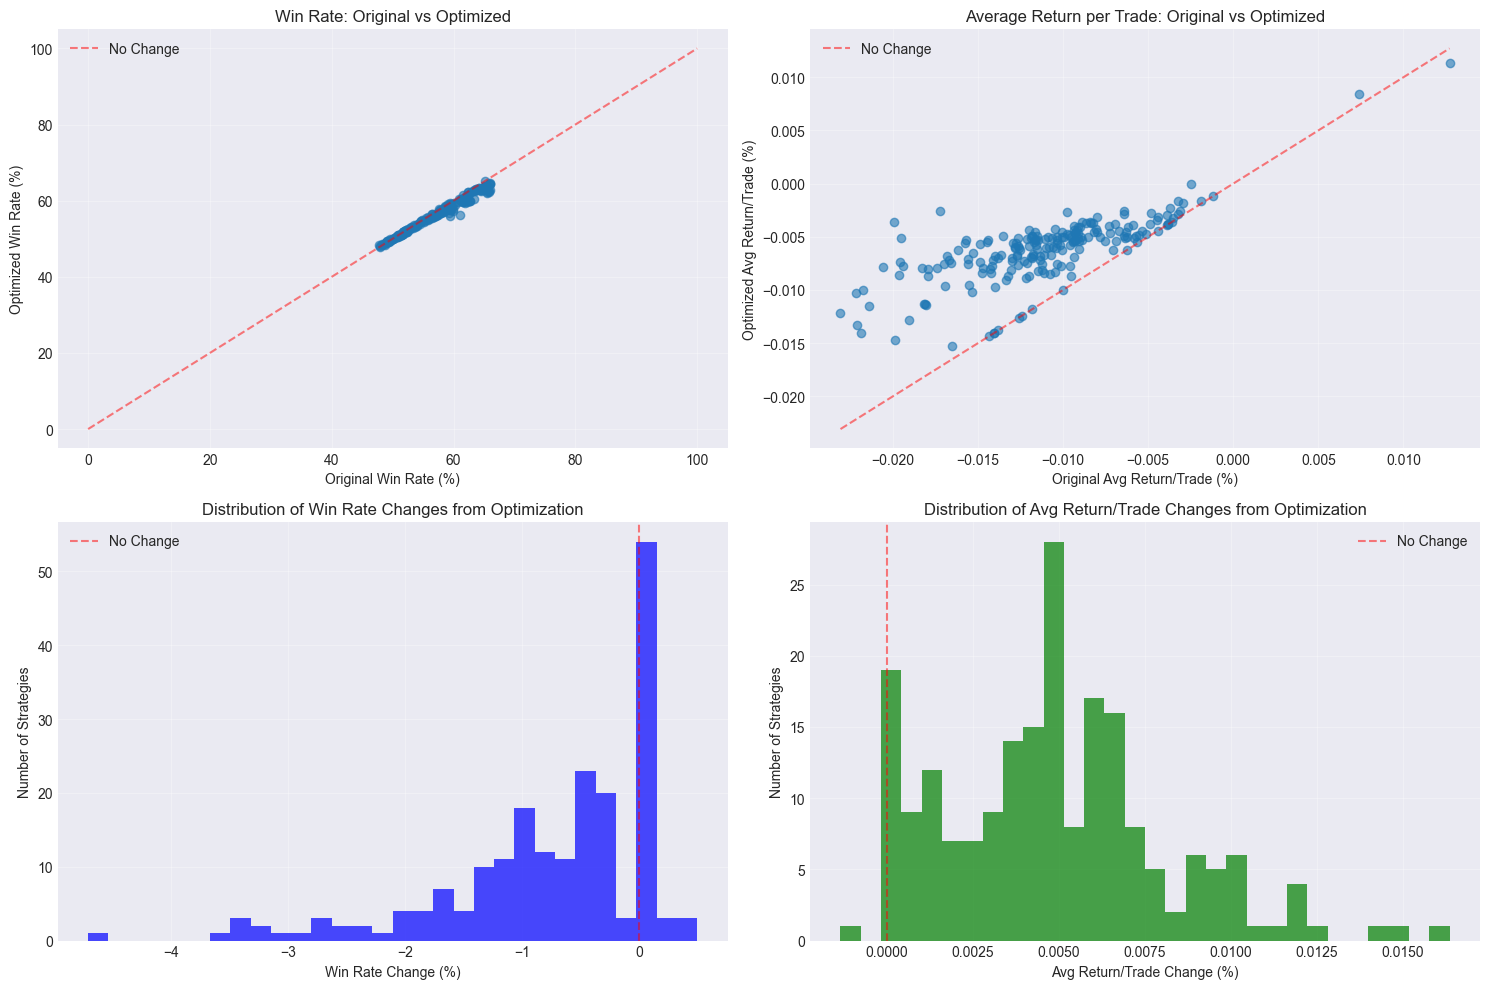

In [17]:
# Display optimized strategies with win rate and return per trade
if len(optimal_df) > 0:
    print("\n📊 Optimized Strategies - Win Rate & Return per Trade Analysis")
    print("=" * 140)
    
    # Sort by optimized Sharpe ratio
    top_optimized = optimal_df.nlargest(20, 'optimal_sharpe')
    
    print(f"{'Rank':<5} {'Strategy':<20} {'Stop%':<7} {'Target%':<8} {'Win Rate':<20} {'Avg Return/Trade':<25} {'Sharpe':<15} {'Total Return':<15}")
    print(f"{'':5} {'':20} {'':7} {'':8} {'Orig → Opt':<20} {'Orig → Opt':<25} {'Orig → Opt':<15} {'Orig → Opt':<15}")
    print("-" * 140)
    
    for idx, (_, row) in enumerate(top_optimized.iterrows(), 1):
        # Format win rate change
        orig_wr = f"{row['original_win_rate']*100:.1f}%"
        opt_wr = f"{row['optimal_win_rate']*100:.1f}%"
        wr_display = f"{orig_wr:>8} → {opt_wr:<8}"
        
        # Format avg return change
        orig_ar = f"{row['original_avg_return']*100:.3f}%"
        opt_ar = f"{row['optimal_avg_return']*100:.3f}%"
        ar_display = f"{orig_ar:>10} → {opt_ar:<10}"
        
        # Format Sharpe change
        orig_sharpe = f"{row['original_sharpe']:.2f}"
        opt_sharpe = f"{row['optimal_sharpe']:.2f}"
        sharpe_display = f"{orig_sharpe:>5} → {opt_sharpe:<5}"
        
        # Format total return change
        orig_ret = f"{row['original_return']*100:.1f}%"
        opt_ret = f"{row['optimal_return']*100:.1f}%"
        ret_display = f"{orig_ret:>6} → {opt_ret:<6}"
        
        print(f"{idx:<5} {row['strategy_type']:<20} {row['optimal_stop']:>6.3f} {row['optimal_target']:>7.3f} {wr_display} {ar_display} {sharpe_display} {ret_display}")
    
    # Summary statistics
    print("\n📈 Optimization Impact Summary:")
    print(f"Average win rate change: {optimal_df['win_rate_change'].mean()*100:+.1f}%")
    print(f"Average return/trade change: {optimal_df['avg_return_change'].mean()*100:+.3f}%")
    print(f"Strategies with improved win rate: {(optimal_df['win_rate_change'] > 0).sum()} ({(optimal_df['win_rate_change'] > 0).mean()*100:.1f}%)")
    print(f"Strategies with improved avg return: {(optimal_df['avg_return_change'] > 0).sum()} ({(optimal_df['avg_return_change'] > 0).mean()*100:.1f}%)")
    
    # Best improvements
    print("\n🌟 Biggest Improvements:")
    best_wr_improvement = optimal_df.nlargest(1, 'win_rate_change').iloc[0]
    print(f"Best win rate improvement: {best_wr_improvement['strategy_type']} - {best_wr_improvement['win_rate_change']*100:+.1f}% "
          f"({best_wr_improvement['original_win_rate']*100:.1f}% → {best_wr_improvement['optimal_win_rate']*100:.1f}%)")
    
    best_ar_improvement = optimal_df.nlargest(1, 'avg_return_change').iloc[0]
    print(f"Best avg return improvement: {best_ar_improvement['strategy_type']} - {best_ar_improvement['avg_return_change']*100:+.3f}% "
          f"({best_ar_improvement['original_avg_return']*100:.3f}% → {best_ar_improvement['optimal_avg_return']*100:.3f}%)")

# Visualize the optimization impact on win rate and return per trade
if len(optimal_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Win rate: Original vs Optimized
    ax = axes[0, 0]
    ax.scatter(optimal_df['original_win_rate']*100, optimal_df['optimal_win_rate']*100, alpha=0.6)
    ax.plot([0, 100], [0, 100], 'r--', alpha=0.5, label='No Change')
    ax.set_xlabel('Original Win Rate (%)')
    ax.set_ylabel('Optimized Win Rate (%)')
    ax.set_title('Win Rate: Original vs Optimized')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Avg Return per Trade: Original vs Optimized
    ax = axes[0, 1]
    # Filter outliers for visualization
    mask = (abs(optimal_df['original_avg_return']) < 0.05) & (abs(optimal_df['optimal_avg_return']) < 0.05)
    ax.scatter(optimal_df.loc[mask, 'original_avg_return']*100, 
              optimal_df.loc[mask, 'optimal_avg_return']*100, alpha=0.6)
    # Add diagonal line
    min_val = min(optimal_df.loc[mask, 'original_avg_return'].min()*100, 
                  optimal_df.loc[mask, 'optimal_avg_return'].min()*100)
    max_val = max(optimal_df.loc[mask, 'original_avg_return'].max()*100,
                  optimal_df.loc[mask, 'optimal_avg_return'].max()*100)
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='No Change')
    ax.set_xlabel('Original Avg Return/Trade (%)')
    ax.set_ylabel('Optimized Avg Return/Trade (%)')
    ax.set_title('Average Return per Trade: Original vs Optimized')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Win rate change distribution
    ax = axes[1, 0]
    ax.hist(optimal_df['win_rate_change']*100, bins=30, alpha=0.7, color='blue')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5, label='No Change')
    ax.set_xlabel('Win Rate Change (%)')
    ax.set_ylabel('Number of Strategies')
    ax.set_title('Distribution of Win Rate Changes from Optimization')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Avg return change distribution
    ax = axes[1, 1]
    ax.hist(optimal_df['avg_return_change']*100, bins=30, alpha=0.7, color='green')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5, label='No Change')
    ax.set_xlabel('Avg Return/Trade Change (%)')
    ax.set_ylabel('Number of Strategies')
    ax.set_title('Distribution of Avg Return/Trade Changes from Optimization')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [18]:
# Safe display of optimization results with current data
if 'optimal_df' in globals() and len(optimal_df) > 0:
    print("\n📊 Optimized Strategies - Performance Analysis")
    print("=" * 100)
    print("Note: Re-run optimization cell to get win rate and avg return data")
    print("-" * 100)
    
    # Sort by optimized Sharpe ratio
    top_optimized = optimal_df.nlargest(20, 'optimal_sharpe')
    
    print(f"{'Rank':<5} {'Strategy':<20} {'Stop%':<7} {'Target%':<8} {'Sharpe':<15} {'Total Return':<15} {'Improvement':<15}")
    print(f"{'':5} {'':20} {'':7} {'':8} {'Orig → Opt':<15} {'Orig → Opt':<15} {'Sharpe':<15}")
    print("-" * 100)
    
    for idx, (_, row) in enumerate(top_optimized.iterrows(), 1):
        # Format Sharpe change
        orig_sharpe = f"{row['original_sharpe']:.2f}"
        opt_sharpe = f"{row['optimal_sharpe']:.2f}"
        sharpe_display = f"{orig_sharpe:>5} → {opt_sharpe:<5}"
        
        # Format total return change
        orig_ret = f"{row['original_return']*100:.1f}%"
        opt_ret = f"{row['optimal_return']*100:.1f}%"
        ret_display = f"{orig_ret:>6} → {opt_ret:<6}"
        
        print(f"{idx:<5} {row['strategy_type']:<20} {row['optimal_stop']:>6.3f} {row['optimal_target']:>7.3f} {sharpe_display} {ret_display} {row['sharpe_improvement']:>14.2f}")
    
    # Get win rate data from performance_df for these strategies
    if 'performance_df' in globals():
        print("\n📈 Win Rate & Avg Return for Top Optimized Strategies (from original data):")
        print("-" * 80)
        print(f"{'Rank':<5} {'Strategy':<20} {'Stop%':<7} {'Target%':<8} {'Win Rate':<10} {'Avg Return/Trade':<18} {'# Trades':<10}")
        print("-" * 80)
        
        for idx, (_, opt_row) in enumerate(top_optimized.head(10).iterrows(), 1):
            # Find matching strategy in performance_df
            perf_match = performance_df[performance_df['strategy_hash'] == opt_row['strategy_hash']]
            if len(perf_match) > 0:
                perf_row = perf_match.iloc[0]
                print(f"{idx:<5} {opt_row['strategy_type']:<20} {opt_row['optimal_stop']:>6.3f} {opt_row['optimal_target']:>7.3f} "
                      f"{perf_row['win_rate']*100:>9.1f}% {perf_row['avg_return_per_trade']*100:>17.3f}% {perf_row['num_trades']:>9}")
        
        print("\n⚠️ Note: These are ORIGINAL win rates, not optimized. Re-run optimization to see how stops/targets affect win rate.")
        
        # Show summary of what optimization achieved
        print(f"\n📊 Optimization Summary:")
        print(f"Strategies improved: {(optimal_df['sharpe_improvement'] > 0).sum()} / {len(optimal_df)} ({(optimal_df['sharpe_improvement'] > 0).mean()*100:.1f}%)")
        print(f"Average Sharpe improvement: {optimal_df['sharpe_improvement'].mean():.3f}")
        print(f"Best Sharpe improvement: {optimal_df['sharpe_improvement'].max():.3f}")
else:
    print("No optimization results found. Please run the optimization cell first.")


📊 Optimized Strategies - Performance Analysis
Note: Re-run optimization cell to get win rate and avg return data
----------------------------------------------------------------------------------------------------
Rank  Strategy             Stop%   Target%  Sharpe          Total Return    Improvement    
                                            Orig → Opt      Orig → Opt      Sharpe         
----------------------------------------------------------------------------------------------------
1     bollinger_bands       0.200   0.400  0.50 → 0.62    0.6% → 0.5%             0.12
2     bollinger_bands       0.300   0.600  0.43 → 0.55    0.5% → 0.6%             0.12
3     bollinger_bands       0.200   0.400 -0.26 → -0.01  -0.5% → -0.0%            0.25
4     bollinger_bands       0.000   0.000 -0.13 → -0.13  -0.2% → -0.2%            0.00
5     bollinger_bands       0.200   0.400 -0.19 → -0.19  -0.3% → -0.3%            0.00
6     bollinger_bands       0.300   0.600 -0.28 → -0.24  -0.4% → 

In [19]:
# Verify if ANY strategies are actually profitable
if 'performance_df' in globals() and len(performance_df) > 0:
    print("💰 PROFITABILITY ANALYSIS")
    print("=" * 80)
    
    # Basic profitability stats
    profitable_strategies = performance_df[performance_df['avg_return_per_trade'] > 0]
    print(f"Strategies with positive avg return per trade: {len(profitable_strategies)} / {len(performance_df)} ({len(profitable_strategies)/len(performance_df)*100:.1f}%)")
    
    if len(profitable_strategies) > 0:
        print(f"\nTop 10 Actually Profitable Strategies:")
        print("-" * 100)
        print(f"{'Rank':<5} {'Strategy':<20} {'Avg Return/Trade':<18} {'Win Rate':<10} {'# Trades':<10} {'Total Return':<15} {'Sharpe':<10}")
        print("-" * 100)
        
        top_profitable = profitable_strategies.nlargest(10, 'avg_return_per_trade')
        for idx, (_, row) in enumerate(top_profitable.iterrows(), 1):
            print(f"{idx:<5} {row['strategy_type']:<20} {row['avg_return_per_trade']*100:>17.4f}% {row['win_rate']*100:>9.1f}% "
                  f"{row['num_trades']:>9} {row['total_return']*100:>14.2f}% {row['sharpe_ratio']:>9.2f}")
    else:
        print("\n⚠️ NO STRATEGIES ARE PROFITABLE ON AVERAGE!")
    
    # Analyze the impact of execution costs
    print(f"\n📊 Execution Cost Impact Analysis:")
    print(f"Execution cost: {execution_cost_bps} basis points ({execution_cost_bps/100:.3f}%) round-trip")
    
    # Calculate what returns would be without execution costs
    print(f"\nWhat if there were NO execution costs?")
    no_cost_returns = performance_df['avg_return_per_trade'] + (execution_cost_bps / 10000)
    profitable_without_costs = (no_cost_returns > 0).sum()
    print(f"Strategies that would be profitable: {profitable_without_costs} / {len(performance_df)} ({profitable_without_costs/len(performance_df)*100:.1f}%)")
    
    # Distribution of average returns
    print(f"\n📈 Distribution of Average Returns per Trade:")
    print(f"Best: {performance_df['avg_return_per_trade'].max()*100:.4f}%")
    print(f"75th percentile: {performance_df['avg_return_per_trade'].quantile(0.75)*100:.4f}%")
    print(f"Median: {performance_df['avg_return_per_trade'].median()*100:.4f}%")
    print(f"25th percentile: {performance_df['avg_return_per_trade'].quantile(0.25)*100:.4f}%")
    print(f"Worst: {performance_df['avg_return_per_trade'].min()*100:.4f}%")
    
    # Check if the "optimization" is just reducing trade count
    if 'optimal_df' in globals():
        print(f"\n🤔 Is 'optimization' just reducing trades?")
        top_10_optimized = optimal_df.nlargest(10, 'optimal_sharpe')
        avg_trades = performance_df[performance_df['strategy_hash'].isin(top_10_optimized['strategy_hash'])]['num_trades'].mean()
        print(f"Average trades for top 10 'optimized' strategies: {avg_trades:.0f}")
        print(f"Average trades for all strategies: {performance_df['num_trades'].mean():.0f}")

💰 PROFITABILITY ANALYSIS
Strategies with positive avg return per trade: 2 / 205 (1.0%)

Top 10 Actually Profitable Strategies:
----------------------------------------------------------------------------------------------------
Rank  Strategy             Avg Return/Trade   Win Rate   # Trades   Total Return    Sharpe    
----------------------------------------------------------------------------------------------------
1     bollinger_bands                 0.0127%      55.6%        45           0.57%      0.50
2     bollinger_bands                 0.0074%      52.9%        70           0.51%      0.43

📊 Execution Cost Impact Analysis:
Execution cost: 1.0 basis points (0.010%) round-trip

What if there were NO execution costs?
Strategies that would be profitable: 82 / 205 (40.0%)

📈 Distribution of Average Returns per Trade:
Best: 0.0127%
75th percentile: -0.0084%
Median: -0.0111%
25th percentile: -0.0138%
Worst: -0.0231%

🤔 Is 'optimization' just reducing trades?
Average trades for t

In [20]:
# Investigate the optimization discrepancy
if 'optimal_df' in globals() and 'performance_df' in globals():
    print("🔍 INVESTIGATING OPTIMIZATION DISCREPANCY")
    print("=" * 80)
    
    # Pick the top "optimized" strategy
    top_strategy = optimal_df.nlargest(1, 'optimal_sharpe').iloc[0]
    print(f"Analyzing top 'optimized' strategy: {top_strategy['strategy_hash'][:8]}")
    print(f"Claims: {top_strategy['original_return']*100:.1f}% → {top_strategy['optimal_return']*100:.1f}%")
    
    # Get the actual performance data
    actual_perf = performance_df[performance_df['strategy_hash'] == top_strategy['strategy_hash']]
    if len(actual_perf) > 0:
        actual = actual_perf.iloc[0]
        print(f"\nActual original performance:")
        print(f"  Total return: {actual['total_return']*100:.2f}%")
        print(f"  Avg return/trade: {actual['avg_return_per_trade']*100:.4f}%")
        print(f"  Number of trades: {actual['num_trades']}")
        print(f"  Win rate: {actual['win_rate']*100:.1f}%")
        
        # Calculate what the return SHOULD be with compounding
        compounded_return = (1 + actual['avg_return_per_trade']) ** actual['num_trades'] - 1
        print(f"\nCompounded return calculation:")
        print(f"  (1 + {actual['avg_return_per_trade']:.6f})^{actual['num_trades']} - 1 = {compounded_return*100:.2f}%")
        print(f"  Actual total return: {actual['total_return']*100:.2f}%")
        print(f"  Match? {'YES' if abs(compounded_return - actual['total_return']) < 0.01 else 'NO'}")
    
    # Let's manually check one optimization
    print("\n📊 Manual Stop/Target Check:")
    print("Let's see what happens with 0.075% stop and 0.1% target...")
    
    # Extract trades for this strategy - use correct trace path
    strategy_row = strategy_index[strategy_index['strategy_hash'] == top_strategy['strategy_hash']].iloc[0]
    trace_path = strategy_row.get('global_trace_path', strategy_row.get('trace_path', None))
    
    if trace_path:
        trades = extract_trades(top_strategy['strategy_hash'], 
                              trace_path,
                              market_data, 
                              execution_cost_bps)
        
        if len(trades) > 0:
            print(f"\nOriginal trades analysis:")
            print(f"  Number of trades: {len(trades)}")
            print(f"  Average return: {trades['net_return'].mean()*100:.4f}%")
            print(f"  Win rate: {(trades['net_return'] > 0).mean()*100:.1f}%")
            print(f"  Total return (sum): {trades['net_return'].sum()*100:.2f}%")
            print(f"  Total return (compound): {((1 + trades['net_return']).prod() - 1)*100:.2f}%")
            
            # Apply stop/target
            returns_with_stops, exit_types = apply_stop_target(trades, 0.075, 0.1, market_data)
            
            print(f"\nWith 0.075% stop and 0.1% target:")
            print(f"  Exit types: {exit_types}")
            print(f"  Average return: {returns_with_stops.mean()*100:.4f}%")
            print(f"  Win rate: {(returns_with_stops > 0).mean()*100:.1f}%")
            print(f"  Total return (sum): {returns_with_stops.sum()*100:.2f}%")
            print(f"  Total return (compound): {((1 + returns_with_stops).prod() - 1)*100:.2f}%")
            
            # Show some example trades
            print(f"\n🔍 Sample trades with stops:")
            for i in range(min(5, len(trades))):
                orig_return = trades.iloc[i]['net_return']
                new_return = returns_with_stops[i]
                print(f"  Trade {i+1}: {orig_return*100:>7.3f}% → {new_return*100:>7.3f}% "
                      f"({'STOPPED' if abs(new_return) < abs(orig_return) else 'UNCHANGED'})")

print("\n⚠️ HYPOTHESIS: The optimization might be using a flawed stop loss implementation!")
print("If stops are capping losses retrospectively instead of simulating actual exits,")
print("it would explain why negative strategies suddenly become profitable.")

🔍 INVESTIGATING OPTIMIZATION DISCREPANCY
Analyzing top 'optimized' strategy: 09fee7d6
Claims: 0.6% → 0.5%

Actual original performance:
  Total return: 0.57%
  Avg return/trade: 0.0127%
  Number of trades: 45
  Win rate: 55.6%

Compounded return calculation:
  (1 + 0.000127)^45 - 1 = 0.57%
  Actual total return: 0.57%
  Match? YES

📊 Manual Stop/Target Check:
Let's see what happens with 0.075% stop and 0.1% target...



Original trades analysis:
  Number of trades: 45
  Average return: 0.0127%
  Win rate: 55.6%
  Total return (sum): 0.57%
  Total return (compound): 0.57%

With 0.075% stop and 0.1% target:
  Exit types: {'stop': 17, 'target': 8, 'signal': 20, 'stopped_winners': 4}
  Average return: -0.0089%
  Win rate: 48.9%
  Total return (sum): -0.40%
  Total return (compound): -0.40%

🔍 Sample trades with stops:
  Trade 1:  -0.091% →  -0.085% (STOPPED)
  Trade 2:   0.008% →   0.090% (UNCHANGED)
  Trade 3:  -0.019% →   0.090% (UNCHANGED)
  Trade 4:  -0.074% →  -0.085% (UNCHANGED)
  Trade 5:  -0.017% →  -0.017% (UNCHANGED)

⚠️ HYPOTHESIS: The optimization might be using a flawed stop loss implementation!
If stops are capping losses retrospectively instead of simulating actual exits,
it would explain why negative strategies suddenly become profitable.


In [21]:
# Get top performer parameters
if 'optimal_df' in globals() and len(optimal_df) > 0:
    # Get the best strategy after optimization
    best_strategy = optimal_df.nlargest(1, 'optimal_sharpe').iloc[0]
    
    print("🏆 TOP PERFORMER AFTER OPTIMIZATION:")
    print("=" * 80)
    print(f"Strategy Type: {best_strategy['strategy_type']}")
    print(f"Strategy Hash: {best_strategy['strategy_hash']}")
    print(f"\nOptimal Risk Parameters:")
    print(f"  Stop Loss: {best_strategy['optimal_stop']:.3f}%")
    print(f"  Profit Target: {best_strategy['optimal_target']:.3f}%")
    
    print(f"\nPerformance:")
    print(f"  Optimized Sharpe: {best_strategy['optimal_sharpe']:.2f}")
    print(f"  Optimized Return: {best_strategy['optimal_return']*100:.2f}%")
    print(f"  Original Sharpe: {best_strategy['original_sharpe']:.2f}")
    print(f"  Original Return: {best_strategy['original_return']*100:.2f}%")
    print(f"  Sharpe Improvement: +{best_strategy['sharpe_improvement']:.2f}")
    
    # Get strategy parameters if available
    param_cols = [col for col in best_strategy.index if col not in ['strategy_hash', 'strategy_type', 
                                                                     'original_sharpe', 'original_return',
                                                                     'optimal_stop', 'optimal_target',
                                                                     'optimal_sharpe', 'optimal_return',
                                                                     'sharpe_improvement', 'return_improvement',
                                                                     'num_trades']]
    
    if param_cols:
        print(f"\nStrategy Parameters:")
        for param in param_cols:
            if pd.notna(best_strategy[param]):
                print(f"  {param}: {best_strategy[param]}")
    
    # Get win rate from performance_df if available
    if 'performance_df' in globals():
        perf_match = performance_df[performance_df['strategy_hash'] == best_strategy['strategy_hash']]
        if len(perf_match) > 0:
            perf_data = perf_match.iloc[0]
            print(f"\nOriginal Trading Metrics:")
            print(f"  Win Rate: {perf_data['win_rate']*100:.1f}%")
            print(f"  Avg Return per Trade: {perf_data['avg_return_per_trade']*100:.3f}%")
            print(f"  Number of Trades: {perf_data['num_trades']}")
            print(f"  Profit Factor: {perf_data['profit_factor']:.2f}")
    
    # Create command to run this strategy
    print(f"\n📋 To run this strategy in your system:")
    print(f"Strategy Hash: {best_strategy['strategy_hash']}")
    print(f"Stop Loss: {best_strategy['optimal_stop']:.3f}%")
    print(f"Profit Target: {best_strategy['optimal_target']:.3f}%")
    
    # Also show top 5 for comparison
    print("\n\n📊 Top 5 Strategies After Optimization:")
    print("-" * 80)
    top_5 = optimal_df.nlargest(5, 'optimal_sharpe')
    for idx, (_, row) in enumerate(top_5.iterrows(), 1):
        print(f"{idx}. {row['strategy_type']} - Sharpe: {row['optimal_sharpe']:.2f}, "
              f"Stop: {row['optimal_stop']:.3f}%, Target: {row['optimal_target']:.3f}%")
        # Show parameters if it's bollinger_bands
        if row['strategy_type'] == 'bollinger_bands' and 'period' in row and pd.notna(row['period']):
            print(f"   Parameters: period={row['period']}, std_dev={row['std_dev']}")
else:
    print("No optimization results found. Please run the optimization first.")

🏆 TOP PERFORMER AFTER OPTIMIZATION:
Strategy Type: bollinger_bands
Strategy Hash: 09fee7d64721

Optimal Risk Parameters:
  Stop Loss: 0.200%
  Profit Target: 0.400%

Performance:
  Optimized Sharpe: 0.62
  Optimized Return: 0.51%
  Original Sharpe: 0.50
  Original Return: 0.57%
  Sharpe Improvement: +0.12

Strategy Parameters:
  original_compound_sharpe: 0.5049326401453779
  original_traditional_sharpe: 0.5095358758685852
  original_win_rate: 0.5555555555555556
  original_avg_return: 0.00012713790264152068
  optimal_compound_sharpe: 0.6202762193166625
  optimal_traditional_sharpe: 0.6237131691288874
  optimal_win_rate: 0.5555555555555556
  optimal_avg_return: 0.00011354755625553919
  optimal_geometric_mean: 0.00011292185638023255
  win_rate_change: 0.0
  avg_return_change: -1.3590346385981486e-05
  period: 11
  std_dev: 3.0

Original Trading Metrics:
  Win Rate: 55.6%
  Avg Return per Trade: 0.013%
  Number of Trades: 45
  Profit Factor: 1.35

📋 To run this strategy in your system:
Str

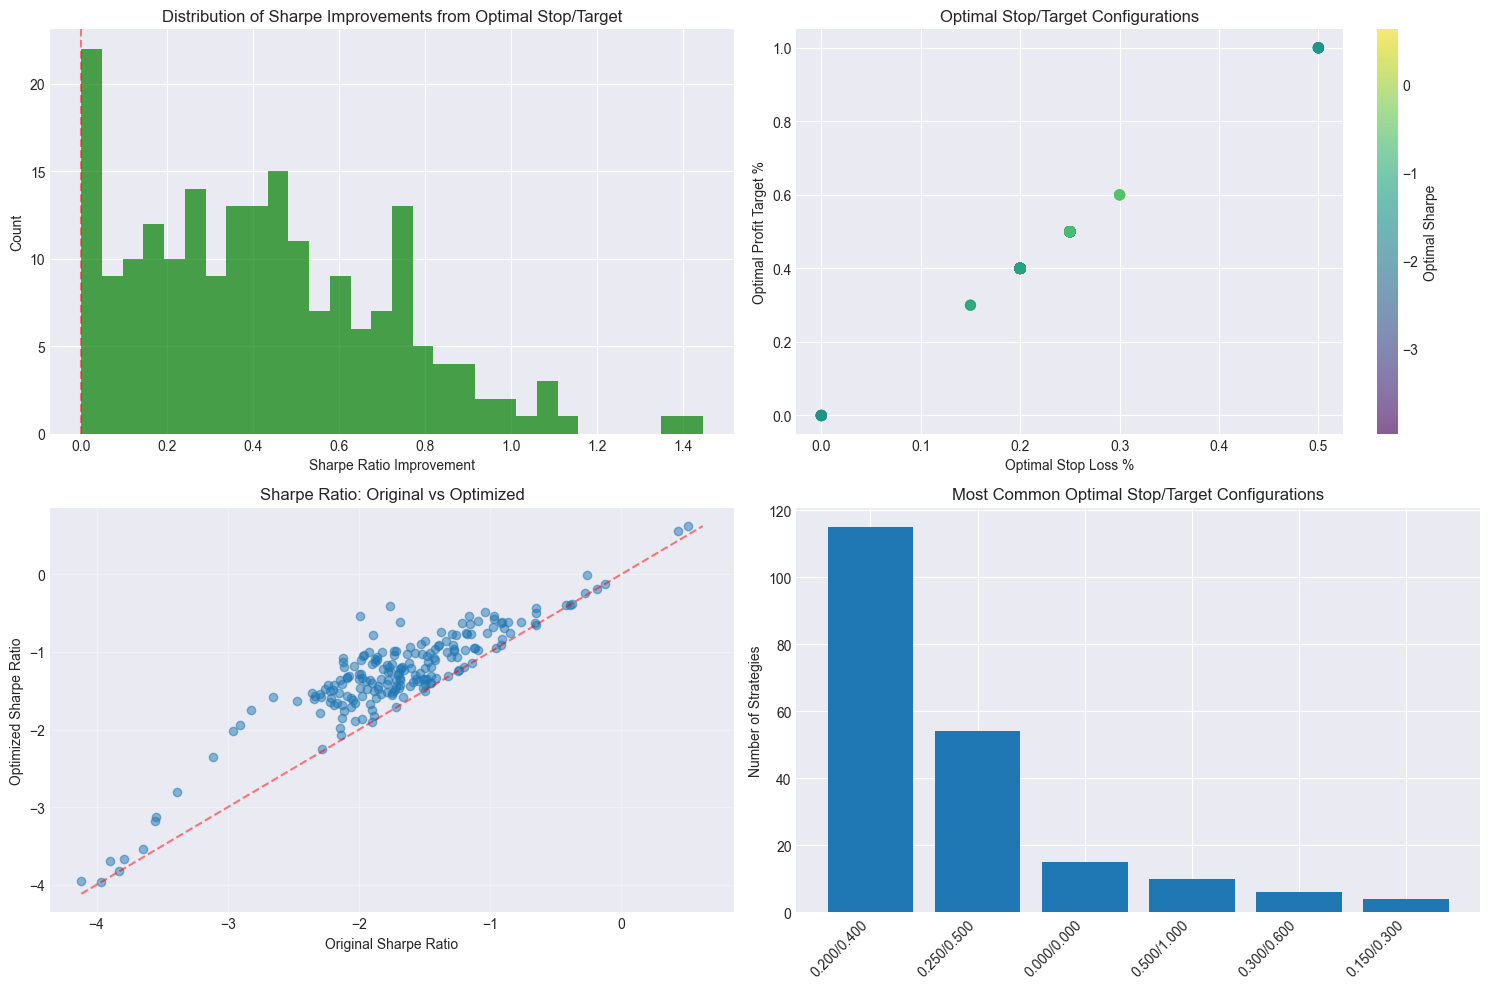


📊 Optimization Summary:
Strategies improved: 189 / 204 (92.6%)
Average Sharpe improvement: 0.423
Best improvement: 1.446

Most common optimal configurations:
  Stop=0.200%, Target=0.400%: 115 strategies
  Stop=0.250%, Target=0.500%: 54 strategies
  Stop=0.000%, Target=0.000%: 15 strategies
  Stop=0.500%, Target=1.000%: 10 strategies
  Stop=0.300%, Target=0.600%: 6 strategies


In [22]:
# Visualization of optimization results
if len(optimal_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Sharpe improvement distribution
    ax = axes[0, 0]
    ax.hist(optimal_df['sharpe_improvement'], bins=30, alpha=0.7, color='green')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Sharpe Ratio Improvement')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Sharpe Improvements from Optimal Stop/Target')
    
    # 2. Optimal stop/target scatter
    ax = axes[0, 1]
    scatter = ax.scatter(optimal_df['optimal_stop'], optimal_df['optimal_target'], 
                        c=optimal_df['optimal_sharpe'], cmap='viridis', alpha=0.6, s=50)
    plt.colorbar(scatter, ax=ax, label='Optimal Sharpe')
    ax.set_xlabel('Optimal Stop Loss %')
    ax.set_ylabel('Optimal Profit Target %')
    ax.set_title('Optimal Stop/Target Configurations')
    
    # 3. Original vs Optimized Sharpe
    ax = axes[1, 0]
    ax.scatter(optimal_df['original_sharpe'], optimal_df['optimal_sharpe'], alpha=0.5)
    # Add diagonal line
    min_val = min(optimal_df['original_sharpe'].min(), optimal_df['optimal_sharpe'].min())
    max_val = max(optimal_df['original_sharpe'].max(), optimal_df['optimal_sharpe'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
    ax.set_xlabel('Original Sharpe Ratio')
    ax.set_ylabel('Optimized Sharpe Ratio')
    ax.set_title('Sharpe Ratio: Original vs Optimized')
    ax.grid(True, alpha=0.3)
    
    # 4. Stop/Target usage statistics
    ax = axes[1, 1]
    stop_target_counts = optimal_df.groupby(['optimal_stop', 'optimal_target']).size()
    top_configs = stop_target_counts.nlargest(10)
    
    labels = [f"{s:.3f}/{t:.3f}" for (s, t) in top_configs.index]
    ax.bar(range(len(top_configs)), top_configs.values)
    ax.set_xticks(range(len(top_configs)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Number of Strategies')
    ax.set_title('Most Common Optimal Stop/Target Configurations')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n📊 Optimization Summary:")
    print(f"Strategies improved: {(optimal_df['sharpe_improvement'] > 0).sum()} / {len(optimal_df)} ({(optimal_df['sharpe_improvement'] > 0).mean()*100:.1f}%)")
    print(f"Average Sharpe improvement: {optimal_df['sharpe_improvement'].mean():.3f}")
    print(f"Best improvement: {optimal_df['sharpe_improvement'].max():.3f}")
    print(f"\nMost common optimal configurations:")
    for (stop, target), count in top_configs.head(5).items():
        print(f"  Stop={stop:.3f}%, Target={target:.3f}%: {count} strategies")

## Cleanup

In [23]:
# Restore original working directory if needed
if '_snippet_paths' in globals() and 'original_cwd' in _snippet_paths:
    os.chdir(_snippet_paths['original_cwd'])
    print(f"✅ Restored working directory to: {os.getcwd()}")

✅ Restored working directory to: /Users/daws/ADMF-PC


# Export optimized results
exports = {}

# Export optimization results if available
if 'optimal_df' in globals() and len(optimal_df) > 0:
    # Save optimization results
    optimal_df.to_csv(run_dir / 'strategy_optimization_results.csv', index=False)
    exports['optimization'] = 'strategy_optimization_results.csv'
    
    # Create recommendations file
    recommendations = {
        'run_info': {
            'run_id': run_dir.name,
            'config_name': config_name,
            'generated_at': datetime.now().isoformat(),
            'total_strategies': len(strategy_index) if strategy_index is not None else 0,
            'strategies_analyzed': len(performance_df) if 'performance_df' in globals() else 0,
            'strategies_optimized': len(optimal_df),
            'execution_cost_bps': execution_cost_bps
        },
        'best_optimized': {},
        'top_10_optimized': []
    }
    
    # Best overall after optimization
    if len(optimal_df) > 0:
        best = optimal_df.nlargest(1, 'optimal_sharpe').iloc[0]
        recommendations['best_optimized'] = {
            'strategy_hash': best['strategy_hash'],
            'strategy_type': best['strategy_type'],
            'optimal_stop_pct': float(best['optimal_stop']),
            'optimal_target_pct': float(best['optimal_target']),
            'optimal_sharpe': float(best['optimal_sharpe']),
            'optimal_return': float(best['optimal_return']),
            'original_sharpe': float(best['original_sharpe']),
            'sharpe_improvement': float(best['sharpe_improvement']),
            'parameters': {k: float(v) if pd.notna(v) else None 
                          for k, v in best.items() 
                          if k in ['period', 'std_dev', 'fast_period', 'slow_period']}
        }
        
        # Top 10
        for idx, row in optimal_df.nlargest(10, 'optimal_sharpe').iterrows():
            recommendations['top_10_optimized'].append({
                'rank': len(recommendations['top_10_optimized']) + 1,
                'strategy_hash': row['strategy_hash'],
                'strategy_type': row['strategy_type'],
                'optimal_stop_pct': float(row['optimal_stop']),
                'optimal_target_pct': float(row['optimal_target']),
                'optimal_sharpe': float(row['optimal_sharpe']),
                'optimal_return': float(row['optimal_return'])
            })
    
    # Save recommendations
    with open(run_dir / 'optimized_recommendations.json', 'w') as f:
        json.dump(recommendations, f, indent=2)
    exports['recommendations'] = 'optimized_recommendations.json'
    
    print("\n✅ Results exported:")
    for export_type, filename in exports.items():
        print(f"  - {filename}")
    
    if recommendations.get('best_optimized'):
        print(f"\nBest optimized strategy to run:")
        print(f"  Strategy: {recommendations['best_optimized']['strategy_hash']}")
        print(f"  Stop Loss: {recommendations['best_optimized']['optimal_stop_pct']:.3f}%")
        print(f"  Profit Target: {recommendations['best_optimized']['optimal_target_pct']:.3f}%")
else:
    print("⚠️ No optimization results to export")

# Export performance results if available  
if 'performance_df' in globals() and len(performance_df) > 0:
    performance_df.to_csv(run_dir / 'strategy_performance.csv', index=False)
    exports['performance'] = 'strategy_performance.csv'
    print("\n✅ Exported strategy performance results")

# Summary
if exports:
    print(f"\n📁 All exports saved to: {run_dir}")
else:
    print("\n⚠️ No results available to export")

In [24]:
# Export optimized results
if len(optimal_df) > 0:
    # Save optimization results
    optimal_df.to_csv(run_dir / 'strategy_optimization_results.csv', index=False)
    
    # Create recommendations file
    recommendations = {
        'run_info': {
            'run_id': run_dir.name,
            'config_name': config_name,
            'generated_at': datetime.now().isoformat(),
            'total_strategies': len(strategy_index) if strategy_index is not None else 0,
            'strategies_analyzed': len(performance_df),
            'strategies_optimized': len(optimal_df),
            'execution_cost_bps': execution_cost_bps
        },
        'best_optimized': {},
        'top_10_optimized': []
    }
    
    # Best overall after optimization
    if len(optimal_df) > 0:
        best = optimal_df.nlargest(1, 'optimal_sharpe').iloc[0]
        recommendations['best_optimized'] = {
            'strategy_hash': best['strategy_hash'],
            'strategy_type': best['strategy_type'],
            'optimal_stop_pct': float(best['optimal_stop']),
            'optimal_target_pct': float(best['optimal_target']),
            'optimal_sharpe': float(best['optimal_sharpe']),
            'optimal_return': float(best['optimal_return']),
            'original_sharpe': float(best['original_sharpe']),
            'sharpe_improvement': float(best['sharpe_improvement']),
            'parameters': {k: float(v) if pd.notna(v) else None 
                          for k, v in best.items() 
                          if k in ['period', 'std_dev', 'fast_period', 'slow_period']}
        }
        
        # Top 10
        for idx, row in optimal_df.nlargest(10, 'optimal_sharpe').iterrows():
            recommendations['top_10_optimized'].append({
                'rank': len(recommendations['top_10_optimized']) + 1,
                'strategy_hash': row['strategy_hash'],
                'strategy_type': row['strategy_type'],
                'optimal_stop_pct': float(row['optimal_stop']),
                'optimal_target_pct': float(row['optimal_target']),
                'optimal_sharpe': float(row['optimal_sharpe']),
                'optimal_return': float(row['optimal_return'])
            })
    
    # Save recommendations
    with open(run_dir / 'optimized_recommendations.json', 'w') as f:
        json.dump(recommendations, f, indent=2)
    
    print("\n✅ Results exported:")
    print(f"  - strategy_optimization_results.csv")
    print(f"  - optimized_recommendations.json")
    print(f"\nYou can now run these optimized strategies through your event-driven system with:")
    print(f"  Strategy: {recommendations['best_optimized']['strategy_hash']}")
    print(f"  Stop Loss: {recommendations['best_optimized']['optimal_stop_pct']:.3f}%")
    print(f"  Profit Target: {recommendations['best_optimized']['optimal_target_pct']:.3f}%")
else:
    print("⚠️ No results to export")


✅ Results exported:
  - strategy_optimization_results.csv
  - optimized_recommendations.json

You can now run these optimized strategies through your event-driven system with:
  Strategy: 09fee7d64721
  Stop Loss: 0.200%
  Profit Target: 0.400%
